# Get directory information

In [34]:
import os

current_directory = os.getcwd()

dir = os.path.dirname(current_directory)
#print(dir)

# Environment Setup for IF-seqFISH Analysis

The below cell imports necessary libraries including Pandas for data manipulation, Cellpose and BigFISH for image processing, NumPy for numerical operations, and SciPy for spatial distance calculations, also displaying the current version of BigFISH, and enabling inline Matplotlib plots for visualization.

In [6]:
import pandas as pd
import os
%matplotlib inline
from cellpose import io
import numpy as np
import bigfish
import bigfish.stack as stack
import bigfish.detection as detection
import pandas as pd
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt
print("Big-FISH version: {0}".format(bigfish.__version__))

Big-FISH version: 0.6.2


# Directory Creation for IF-seqFISH Analysis

The below cell creates a parent directory and a nested output directory for an IF-seqFISH spot determination, using `os.makedirs` with `exist_ok=True` to ensure directories exist without errors if they're already created.

In [7]:
parent_folder = os.path.join(dir, '1_processed_images')
output_folder = os.path.join(dir, '1_processed_images', "6_IF-seqFISH_spot_determination")
os.makedirs(output_folder, exist_ok=True)

# Image Processing for Fluorescence Images

The below cell features two functions: `read_target_image_IF` for reading fluorescence images from a specified directory, and `detect` for processing these images to detect and analyze fluorescent spots, outputting results as a DataFrame and saving them as CSV files in a specified output directory.

In [8]:
def read_target_image_IF(target_folder, fov_n, file_name):
    file_seg = os.path.join(target_folder, f'Pos{str(fov_n).zfill(2)}', file_name)
    img = io.imread(file_seg)
    return img

def detect(target_folder, file_name, target, fov, output_folder):

    img = read_target_image_IF(target_folder, fov, file_name)
    rna_list = img.copy()
    rna = np.array(rna_list)
    rna_mip = stack.maximum_projection(rna)
    
    spot_radius_px = detection.get_object_radius_pixel(
        voxel_size_nm=(130, 130, 130), 
        object_radius_nm=(200, 200, 200), 
        ndim=3)

    rna_log = stack.log_filter(rna, sigma=spot_radius_px)

    # local maximum detection
    mask = detection.local_maximum_detection(rna_log, min_distance=spot_radius_px)

    # thresholding
    threshold = detection.automated_threshold_setting(rna_log, mask)
    spots, b = detection.spots_thresholding(rna_log, mask, 40)

    spots_subpixel_crop = detection.fit_subpixel(
        image=rna, 
        spots=spots, 
        voxel_size=(130, 130, 130),
        spot_radius=(200, 200, 200))
    
    df_if_fov = pd.DataFrame(data={'z_if': spots.T[0], 'y_if': spots.T[1], 'x_if': spots.T[2], 'z_if_s': spots_subpixel_crop.T[0], 'y_if_s': spots_subpixel_crop.T[1], 'x_if_s': spots_subpixel_crop.T[2], 'FOV': fov, 'Target': file_name, 'Target_name': target})
    df_if_fov.to_csv(os.path.join(output_folder, f"IFspot_{file_name}_{fov}.csv"))

    return df_if_fov

# Test Run for Spot Determination Analysis

The below cell sets up a test run for spot detection in fluorescence imaging. It iterates over a specified range of fields of view (FOV), applying the `detect` function on each FOV. This function processes an image file (`"ND80_C2_TyI.tif"`) for a given target (`"BRD4"`) within a specified folder, and stores the analysis results in an output folder.

In [33]:
target_folder = os.path.join(parent_folder, "3_diveded_files")
file_name = "ND80_C2_TyI.tif"
target = "BRD4"

for fov in range(1, 4):

    df_if_fov = detect(target_folder, file_name, target, fov, output_folder)

100%|██████████| 109/109 [00:00<00:00, 941.12it/s]


# Annotation Data for Selected Targets in Fluorescence Imaging

This table in output of below cell, `df_annotation_selected`, presents a mapping between specific genomic targets and their associated annotation files. The targets include various genes and histone marks such as 'KDM1A', 'TCF3', and 'H3K27ac'. Each target is linked to a unique file, which is presumably an image file (in TIFF format) used for further analysis or reference.

In [10]:
df_annotation_selected = pd.DataFrame({
    'target': ['KDM1A', 'TCF3', 'SIN3A', 'OTX2', 'CHD4', 'H3K27ac', 'ESRRB', 'MED12', 'BRD4', 'SOX2'],
    'file_anno': ['ND75_C1_TyI.tif', 'ND76_C1_TyI.tif', 'ND77_C1_TyI.tif', 'ND79_C1_TyI.tif', 'ND80_C1_TyI.tif', 'ND81_C1_TyI.tif', 'ND76_C2_TyI.tif', 'ND78_C2_TyI.tif', 'ND80_C2_TyI.tif', 'ND80_C3_TyI.tif']
})
df_annotation_selected

,target,file_anno
0,KDM1A,ND75_C1_TyI.tif
1,TCF3,ND76_C1_TyI.tif
2,SIN3A,ND77_C1_TyI.tif
3,OTX2,ND79_C1_TyI.tif
4,CHD4,ND80_C1_TyI.tif
5,H3K27ac,ND81_C1_TyI.tif
6,ESRRB,ND76_C2_TyI.tif
7,MED12,ND78_C2_TyI.tif
8,BRD4,ND80_C2_TyI.tif
9,SOX2,ND80_C3_TyI.tif


# Spot Determination Analysis Across Multiple Targets and FOVs

This below cell iterates over pairs of targets and file names from `df_annotation_selected` DataFrame, applying the `detect` function for each target-file pair across a range of fields of view (1 to 3). The `detect` function processes the specified image files, performs spot detection analysis for each target within each FOV, and stores the results in `df_if_fov`.

In [11]:
for target, file_name in zip(df_annotation_selected['target'], df_annotation_selected['file_anno']):

    for fov in range(1, 4):

        df_if_fov = detect(target_folder, file_name, target, fov, output_folder)

100%|██████████| 109/109 [00:00<00:00, 2543.39it/s]


# Reading and Renaming Columns in DNA Analysis Data

The below cell reads a CSV file (`"seq_DNA-FISH_after_correction_rep1.csv"`) into a DataFrame `df_dna`, sets the first column as the index, and renames columns for better identification, changing `"cell"` to `'IntraFOV_Cell_ID'` and `"old_finalcellID"` to `'Cell_ID'`.

In [12]:
df_dna = pd.read_csv(os.path.join(dir, "2_analyzed_data", "seq_DNA-FISH_after_correction_rep1.csv"), index_col=0)
df_dna.rename(columns={"cell": 'IntraFOV_Cell_ID', "old_finalcellID": "Cell_ID"}, inplace=True)

# Fluorescence Imaging Data Processing and Analysis

1. **Function `seg_load`**: Loads a segmented image for a given FOV from a specified directory.

2. **Function `extract_segid_cellID`**: Takes DNA data (`df_dna`), IF data (`df_if_fov_2`), and a segmented image (`img_seg`) for a specific FOV, extracting cell ID information from the segmented image and appending it to the IF data DataFrame.

3. **Function `extract_each_IF`**: Iterates over a range of FOVs, loads IF data and segmented images, applies `extract_segid_cellID` to associate cell IDs with IF spots, and compiles the data into a single DataFrame.

In [15]:
def seg_load(fov):
    seg_folder = os.path.join(parent_folder, "4_segmentation")

    FOV_seg = f"/Pos{fov:02d}/"
    seg_path = seg_folder + str(FOV_seg) + "02_nuc_seg_human_corrected.tif"
    img_seg = io.imread(seg_path)
    return img_seg

def extract_segid_cellID(df_dna, df_if_fov_2, img_seg, FOV):

    df_if_fov_2.rename(columns={"Target": 'Target antibody'}, inplace=True)
    for z, y, x in zip(df_if_fov_2['z_if'], df_if_fov_2['y_if'], df_if_fov_2['x_if']):
        if(z < img_seg.shape[0] and y < img_seg.shape[1] and x < img_seg.shape[2]):
        
            value_seg = img_seg[z, y, x]
            if value_seg >= 0:
                filtered_data = df_dna[(df_dna['IntraFOV_Cell_ID'] == value_seg) & (df_dna['FOV'] == FOV)]

                if not filtered_data.empty:
                    cell_id = filtered_data['Cell_ID'].values[0]
                    df_if_fov_2.loc[(df_if_fov_2['z_if'] == z) & (df_if_fov_2['y_if'] == y) & (df_if_fov_2['x_if'] == x), 'IntraFOV_Cell_ID'] = int(value_seg)
                    df_if_fov_2.loc[(df_if_fov_2['z_if'] == z) & (df_if_fov_2['y_if'] == y) & (df_if_fov_2['x_if'] == x), "Cell_ID"] = int(cell_id)
    df_if_fov_2.dropna(subset=['Cell_ID', 'IntraFOV_Cell_ID'], inplace=True)
    df_if_fov_2 = df_if_fov_2[['z_if_s', 'y_if_s', 'x_if_s', 'FOV', 'Target antibody', 'IntraFOV_Cell_ID', 'Cell_ID']].reset_index(drop=True)
    df_if_fov_2['x_nm'] = df_if_fov_2['x_if_s']*130
    df_if_fov_2['y_nm'] = df_if_fov_2['y_if_s']*130
    df_if_fov_2['z_nm'] = df_if_fov_2['z_if_s']*130
    df_if_fov_2 = df_if_fov_2.drop(['z_if_s', 'y_if_s', 'x_if_s'], axis=1)
    df_if_fov_2 = df_if_fov_2[['FOV', 'IntraFOV_Cell_ID', 'Cell_ID', 'Target antibody', 'x_nm', 'y_nm', 'z_nm']]
    df_if_fov_2['IntraFOV_Cell_ID'] = df_if_fov_2['IntraFOV_Cell_ID'].astype(int)
    df_if_fov_2['Cell_ID'] = df_if_fov_2['Cell_ID'].astype(int)
    df_if_fov_2['x_nm'] = df_if_fov_2['x_nm'].round(2)
    df_if_fov_2['y_nm'] = df_if_fov_2['y_nm'].round(2)
    df_if_fov_2['z_nm'] = df_if_fov_2['z_nm'].round(2)

    return df_if_fov_2

def extract_each_IF(if_name, image_name):
    
    df_if_fov_2_all = pd.DataFrame()
    for FOV in range(1, 4):
        spot_folder = output_folder
        file_name = f"IFspot_{image_name}_{FOV}.csv"
        df_if_fov = pd.read_csv(os.path.join(spot_folder, file_name), index_col=0)
        df_if_fov_2 = df_if_fov.copy()
        img_seg = seg_load(FOV)
        print(f'Start FOV{FOV}')
        df_if_fov_2 = extract_segid_cellID(df_dna, df_if_fov_2, img_seg, FOV)
        df_if_fov_2_all = pd.concat([df_if_fov_2_all, df_if_fov_2])

    df_if_fov_2_all['Target antibody'] = if_name
    
    return df_if_fov_2_all

# Batch Processing and Exporting Fluorescence Imaging Data

1. **Initializing an Empty DataFrame**: `df_if_fov_2_all_all` is initialized to aggregate data from all iterations.

2. **Iterating Over Targets**: The script iterates over rows in `df_annotation_selected`, representing different imaging targets.

3. **Extracting and Saving Data per Target**:
   - For each target, `extract_each_IF` function is called, processing image data and returning a DataFrame `df_if_fov_2_all`.
   - This DataFrame is then saved as a CSV file named after the target in the `output_folder` directory.

4. **Aggregating Data**:
   - The data for each target is concatenated into `df_if_fov_2_all_all` for a comprehensive dataset.

5. **Saving the Aggregated Data**:
   - The complete dataset containing information for all targets is saved as a CSV file, `seq_IF_FISH_3ROIs_TargetAntibody_foci.csv`, in the `final_out` directory.

In [17]:
df_if_fov_2_all_all = pd.DataFrame()
for row in df_annotation_selected.itertuples():
    print(row[1])
    df_if_fov_2_all = extract_each_IF(row[1], row[2])
    df_if_fov_2_all.to_csv(f'{output_folder}/{row[1]}_foci.csv', index=False)
    
    df_if_fov_2_all_all = pd.concat([df_if_fov_2_all_all, df_if_fov_2_all])

final_out = os.path.join(dir, '2_analyzed_data')
df_if_fov_2_all_all.to_csv(f'{final_out}/seq_IF_FISH_3ROIs_TargetAntibody_foci.csv', index=False)

KDM1A


100%|██████████| 108/108 [00:00<00:00, 4859.15it/s]

Start FOV1



100%|██████████| 127/127 [00:00<00:00, 4167.43it/s]


Start FOV2


100%|██████████| 109/109 [00:00<00:00, 2994.17it/s]


Start FOV3
TCF3


100%|██████████| 108/108 [00:00<00:00, 3154.64it/s]

Start FOV1



100%|██████████| 127/127 [00:00<00:00, 2365.25it/s]


Start FOV2


100%|██████████| 109/109 [00:00<00:00, 3847.40it/s]


Start FOV3
SIN3A


100%|██████████| 108/108 [00:00<00:00, 1935.08it/s]

Start FOV1



100%|██████████| 127/127 [00:00<00:00, 2549.12it/s]


Start FOV2


100%|██████████| 109/109 [00:00<00:00, 5384.09it/s]


Start FOV3
OTX2


100%|██████████| 108/108 [00:00<00:00, 4974.25it/s]

Start FOV1



100%|██████████| 127/127 [00:00<00:00, 2576.35it/s]


Start FOV2


100%|██████████| 109/109 [00:00<00:00, 5816.45it/s]


Start FOV3
CHD4


100%|██████████| 108/108 [00:00<00:00, 5798.28it/s]


Start FOV1


100%|██████████| 127/127 [00:00<00:00, 4066.17it/s]

Start FOV2



100%|██████████| 109/109 [00:00<00:00, 6182.19it/s]


Start FOV3
H3K27ac


100%|██████████| 108/108 [00:00<00:00, 2518.09it/s]

Start FOV1



100%|██████████| 127/127 [00:00<00:00, 3551.15it/s]


Start FOV2


100%|██████████| 109/109 [00:00<00:00, 5764.02it/s]


Start FOV3
ESRRB


100%|██████████| 108/108 [00:00<00:00, 6101.13it/s]

Start FOV1



100%|██████████| 127/127 [00:00<00:00, 4229.10it/s]


Start FOV2


100%|██████████| 109/109 [00:00<00:00, 5724.04it/s]


Start FOV3
MED12


100%|██████████| 108/108 [00:00<00:00, 5223.71it/s]

Start FOV1



100%|██████████| 127/127 [00:00<00:00, 4337.47it/s]


Start FOV2


100%|██████████| 109/109 [00:00<00:00, 5642.52it/s]


Start FOV3
BRD4


100%|██████████| 108/108 [00:00<00:00, 5779.05it/s]

Start FOV1



100%|██████████| 127/127 [00:00<00:00, 3410.81it/s]


Start FOV2


100%|██████████| 109/109 [00:00<00:00, 4805.68it/s]


Start FOV3
SOX2


100%|██████████| 108/108 [00:00<00:00, 5929.35it/s]


Start FOV1


100%|██████████| 127/127 [00:00<00:00, 4635.48it/s]

Start FOV2



100%|██████████| 109/109 [00:00<00:00, 5267.47it/s]

Start FOV3


# Fluorescence Imaging Data Processing Functions

The below cell contains `pix_To_nm` for converting pixel coordinates to nanometers in a DataFrame, and `func_index_dis_min_3d_if` for identifying indices of points in 3D space within a specified distance threshold, applicable in fluorescence imaging analysis.

In [18]:
output_folder_2 = os.path.join(parent_folder, "7_IF-seqFISH_spot_contact")
os.makedirs(output_folder_2, exist_ok=True)

In [19]:
def pix_To_nm(df_dna):
    df_dna['x_hat'] = df_dna['x_hat'] * 130
    df_dna['y_hat'] = df_dna['y_hat'] * 130
    df_dna['z_hat'] = df_dna['z_hat'] * 130
    return df_dna

def func_index_dis_min_3d_if(z, x, y, z_l, x_l, y_l, threshold=350):
    dis_spot = []
    
    for Z, X, Y in zip(z_l, x_l, y_l):
        dis = distance.euclidean((z, x, y), (Z, X, Y))
        dis_spot.append(dis)
    
    min_indices = [i for i, dis in enumerate(dis_spot) if dis <= threshold]
    
    if not min_indices:
        return None, None  # No points within the threshold
    
    return min_indices

# Processing Fluorescence Imaging Data for DNA and RNA, and IF Spots

1. **Read and Rename Columns in DNA Data**:
   - `df_dna` is created by reading a CSV file from a specified directory, setting the first column as the index.
   - Columns are renamed for clarity: `"cell"` to `'IntraFOV_Cell_ID'` and `"old_finalcellID"` to `'Cell_ID'`.

2. **Read and Process RNA Data**:
   - `df_rna` is read from a CSV file, with the first column set as the index.
   - Column `"cell"` is renamed to `'IntraFOV_Cell_ID'`.
   - The dataset is filtered to include rows where `'R_D_dist'` is less than 30.
   - A subset `df_rna_nanog` is created for rows where `'RNA_id'` is equal to `"Nanog"`.
   - `df_dna` is updated to include a `'state'` column, initially set to `"OFF"`. This state is set to `"ON"` for cells with matching `'finalcellID'` in `df_rna_nanog`.

3. **Coordinate Conversion for DNA Data**:
   - The `pix_To_nm` function is applied to `df_dna` to convert pixel coordinates to nanometers.

4. **Read IF Spot Data**:
   - `df_if_spots` is initialized by reading another CSV file from a different specified directory, containing IF spot data.

5. **Filter IF Data for a Specific Target Antibody**:
   - `df_if_h3k27ac` is created by filtering `df_if_spots` for the `'H3K27ac'` target antibody and resetting the index.


In [22]:
df_dna = pd.read_csv(os.path.join(dir, "2_analyzed_data", "seq_DNA-FISH_after_correction_rep1.csv"), index_col=0)
df_dna.rename(columns={"cell": 'IntraFOV_Cell_ID', "old_finalcellID": "Cell_ID"}, inplace=True)

df_rna = pd.read_csv(os.path.join(dir, "2_analyzed_data", "Transcription_state_data_rep1.csv"), index_col=0)
df_rna.rename(columns={"cell": 'IntraFOV_Cell_ID'}, inplace=True)
df_rna = df_rna[df_rna['R_D_dist'] < 30]
df_rna_nanog = df_rna[df_rna['RNA_id'] == "Nanog"]

In [23]:
df_dna['state'] = "OFF"
for on_id in df_rna_nanog['finalcellID'].values:
   on_id = int(on_id)
   df_dna.loc[df_dna['finalcellID'] == on_id, 'state'] = 'ON'

In [24]:
df_dna = pix_To_nm(df_dna)

df_if_spots = pd.read_csv(os.path.join(final_out, "seq_IF_FISH_All_TargetAntibody_foci.csv"))

df_if_h3k27ac = df_if_spots[df_if_spots['Target antibody'] == 'H3K27ac'].reset_index(drop=True)

# Correlation of DNA and IF Spots in Fluorescence Imaging Analysis

1. **Iterating Over Unique FOVs**:
   - The script processes each unique FOV in `df_if_h3k27ac`.

2. **Filtering and Processing by HYB**:
   - For each FOV, it iterates through a range of HYB values (40 to 65), filtering `df_dna` accordingly.

3. **Spot Matching and Distance Calculation**:
   - Within each HYB, the script matches `df_if_h3k27ac_fov` entries based on `Cell_ID`.
   - Calculates the 3D distance between DNA and IF spots using `func_index_dis_min_3d_if`.

4. **Updating DNA DataFrame**:
   - Adds information about the indices of IF spots within a threshold distance to `df_dna`.

5. **Output to CSV**:
   - The updated `df_dna` DataFrame, containing the matched index information, is saved as a CSV file.

In [25]:
for FOV in df_if_h3k27ac['FOV'].unique():
    print(FOV)
    df_if_h3k27ac_fov = df_if_h3k27ac[df_if_h3k27ac['FOV'] == FOV].reset_index(drop=True)

    for HYB in range(40, 66):
        df_dna_fov = df_dna[(df_dna['FOV'] == FOV) & (df_dna['hyb'] == HYB)]

        for row in df_dna_fov.itertuples():
            cell_id = row.Cell_ID
            df_if_h3k27ac_fov_matched = df_if_h3k27ac_fov[df_if_h3k27ac_fov['Cell_ID'] == cell_id]

            x_d, y_d, z_d = row.x_hat, row.y_hat, row.z_hat 

            if not df_if_h3k27ac_fov_matched.empty:
                index_info = func_index_dis_min_3d_if(z_d, x_d, y_d, 
                                                      df_if_h3k27ac_fov_matched['z_nm'].values, 
                                                      df_if_h3k27ac_fov_matched['x_nm'].values, 
                                                      df_if_h3k27ac_fov_matched['y_nm'].values)
                if None not in index_info:
                    index_info_str = ', '.join(map(str, index_info))
                    df_dna.loc[(df_dna['hyb'] == row.hyb) & (df_dna['FOV'] == row.FOV) & 
                               (df_dna['x_hat'] == x_d) & (df_dna['y_hat'] == y_d), 
                               'index_list_thre'] = index_info_str

# Output to CSV
df_dna.to_csv(os.path.join(output_folder_2, "Spots_index_thre350_H3K27ac.csv"))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


# Comprehensive Data Processing and Visualization for contact frequency

1. **Function `optimized_dist_improved`**: Calculates distance matrices for samples based on unique identifiers and XYZ data, handling both numeric and string data types.

2. **Matplotlib Configuration**: Sets global font styles and creates a custom colormap for heatmap visualization.

3. **Data Preparation Functions**:
   - `data_in`: Extracts and formats data from a DataFrame for processing.
   - `plt_matrix`: Generates a heatmap from a given matrix, allowing customization of color scales and axis labels.
   - `np_mean`: Computes the mean of distances across samples for each pair of indices.

4. **Function `out_data_matrix`**: Orchestrates the process of data extraction, distance calculation, and mean computation, returning the distance matrix and its mean.

In [26]:
df_dna_40_66 = df_dna[df_dna["hyb"].isin(range(40, 66))]
df_dna_40_66 = df_dna_40_66[["hyb", "geneID"]].reset_index(drop=True)
df_dna_40_66_unique = df_dna_40_66.drop_duplicates()

In [27]:
def optimized_dist_improved(data_IDs, data_XYZ):
    SAMPLE = np.unique(data_IDs[:,0])
    SAMPLE_num = len(SAMPLE)
    N = np.amax(data_IDs[:, 1]) + 1

    distance = np.full((N, N, SAMPLE_num), 0.0) #np.nan)
    for num, sample in enumerate(SAMPLE):
        index = np.where(data_IDs[:, 0] == sample)
        if len(index[0]) > 1:
            for i in index[0]:
                n = data_IDs[i, 1]
                data_XYZ_i = data_XYZ[i, 0]  # Store value to avoid repeated indexing
                for j in index[0]:
                    m = data_IDs[j, 1]
                    data_XYZ_j = data_XYZ[j, 0]  # Store value to avoid repeated indexing

                    if all(isinstance(value, (int, float, str)) for value in [data_XYZ_i, data_XYZ_j]):
                        if not pd.isnull(data_XYZ_i) and not pd.isnull(data_XYZ_j):
                            if isinstance(data_XYZ_i, str) and any(x in data_XYZ_j.split(', ') for x in data_XYZ_i.split(', ')):
                                distance[n, m, num] = 1
                            elif data_XYZ_i == data_XYZ_j:
                                distance[n, m, num] = 1
            np.fill_diagonal(distance[:, :, num], np.nan)
    mean = np_mean(distance, data_IDs)

    return mean

plt.rcParams["font.size"] = 36
cmap = plt.cm.get_cmap("seismic_r").copy()
cmap.set_bad("gray")

def data_in(df):
    df_IDs = df[["finalcellID", "hyb"]]
    df_XYZ = df[["index_list_thre"]]
    data_IDs = df_IDs.values
    data_XYZ = df_XYZ.values
    return data_IDs, data_XYZ

def plt_matrix(Sigma, C_MIN=None, C_MAX=None, c = "seismic_r", df_axis = df_dna_40_66_unique):
    #C_MAX = 0.2
    if(C_MIN == None):
        C_MIN = np.nanmin(Sigma)
    
    if(C_MAX == None):
        C_MAX = np.nanmax(Sigma)

    np.fill_diagonal(Sigma, np.nan)

    cmap = plt.cm.get_cmap(f"{c}").copy()
    cmap.set_bad("gray")

    plt.rcParams["font.size"] = 36

    #Sigma2 = np.loadtxt(FILE_READ)
    sigma = 370

    C = Sigma
    N = Sigma.shape[0]
    plt.figure(figsize=(10, 10))
    plt.imshow(C, cmap=cmap, vmin=C_MIN, vmax=C_MAX)
    plt.colorbar(ticks=[C_MIN, C_MAX], shrink=0.5, orientation="vertical")

    df_axis = df_axis.sort_values(by="hyb")

    plt.xticks(np.arange(N), df_axis['hyb'], fontsize=12) 
    plt.gca().tick_params(axis='x', which='both', length=0) # 40から66までの数字を表示
    plt.yticks(np.arange(N), df_axis["geneID"], fontsize=12)
    plt.gca().tick_params(axis='y', which='both', length=0)

    return C_MAX

def np_mean(distance, data_IDs):
    N = np.amax(data_IDs[:, 1]) + 1
    Sigma = np.zeros((N, N))
    for n in range(N):
        for m in range(n + 1, N):
            Sigma[n, m] = Sigma[m, n] = np.nanmean(distance[n, m, :])

    return Sigma

def out_data_matrix(df_dna_new):
    data_IDs, data_XYZ = data_in(df_dna_new)
    mean = optimized_dist_improved(data_IDs, data_XYZ)
    return mean

/tmp/ipykernel_30714/2338615714.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("seismic_r").copy()


# Fluorescence Imaging Data Analysis for 'ON' and 'OFF' States

1. **Read Annotated DNA Data**:
   - `df_dna_anno` is created by reading a CSV file that contains annotated DNA spot data.

2. **Filtering Data Based on State**:
   - `df_dna_anno_on`: Filters `df_dna_anno` to include only entries where the state is 'ON'.
   - `df_dna_anno_off`: Similarly, filters for entries where the state is 'OFF'.

3. **Applying Data Processing Functions**:
   - Both subsets (`df_dna_anno_on` and `df_dna_anno_off`) are processed using the `out_data_matrix` function, which returns distance matrices and their means.

4. **Extracting Relevant Data Range**:
   - `mean_on_2` and `mean_off_2`: Extracts a specific range (indices 40 to 65) from the mean matrices of both 'ON' and 'OFF' states for focused analysis.

In [28]:
df_dna_anno = pd.read_csv(os.path.join(output_folder_2, f"Spots_index_thre350_H3K27ac.csv"), index_col=0)
df_dna_anno_on = df_dna_anno[df_dna_anno['state'] == 'ON']
df_dna_anno_off = df_dna_anno[df_dna_anno['state'] == 'OFF']

mean_on = out_data_matrix(df_dna_anno_on)
mean_off = out_data_matrix(df_dna_anno_off)

mean_on_2 = mean_on[40:66, 40:66]
mean_off_2 = mean_off[40:66, 40:66]

# Visualization of frequency for 'ON' and 'OFF' States

The below cell visualizes the mean frequency matrices `mean_on_2` and `mean_off_2` using the `plt_matrix` function. It creates heatmaps for both 'ON' and 'OFF' states with the following specifications:
- Color map set to `"seismic"`.
- Maximum color range value (`C_MAX`) set to 0.3.
- Minimum color range value (`C_MIN`) automatically determined.

/tmp/ipykernel_30714/2338615714.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(f"{c}").copy()


0.3

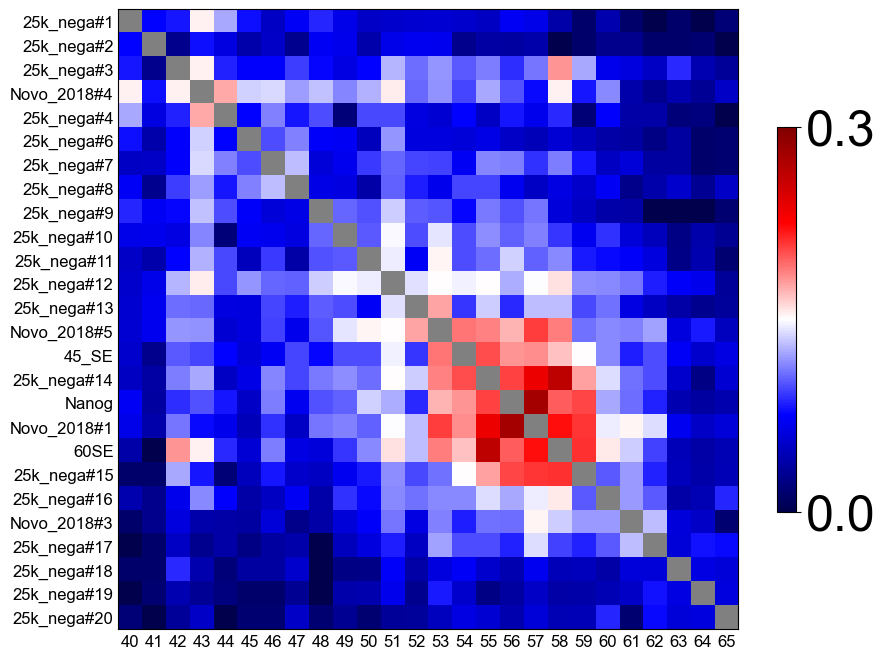

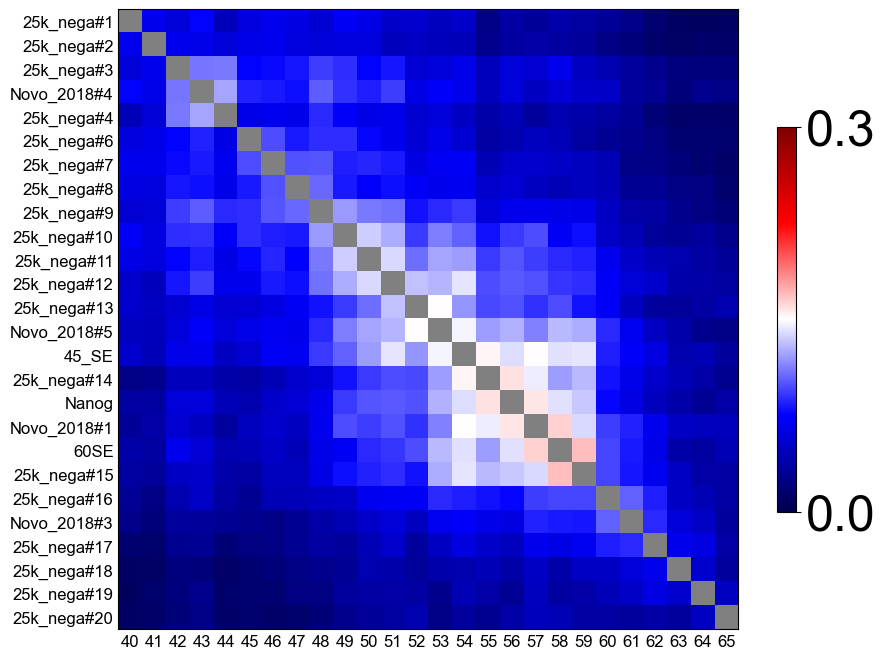

In [32]:
plt_matrix(mean_on_2, C_MIN=0.0, C_MAX=0.3, c = "seismic")
plt_matrix(mean_off_2, C_MIN=0.0, C_MAX=0.3, c = "seismic")

/tmp/ipykernel_30714/2338615714.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(f"{c}").copy()


0.3

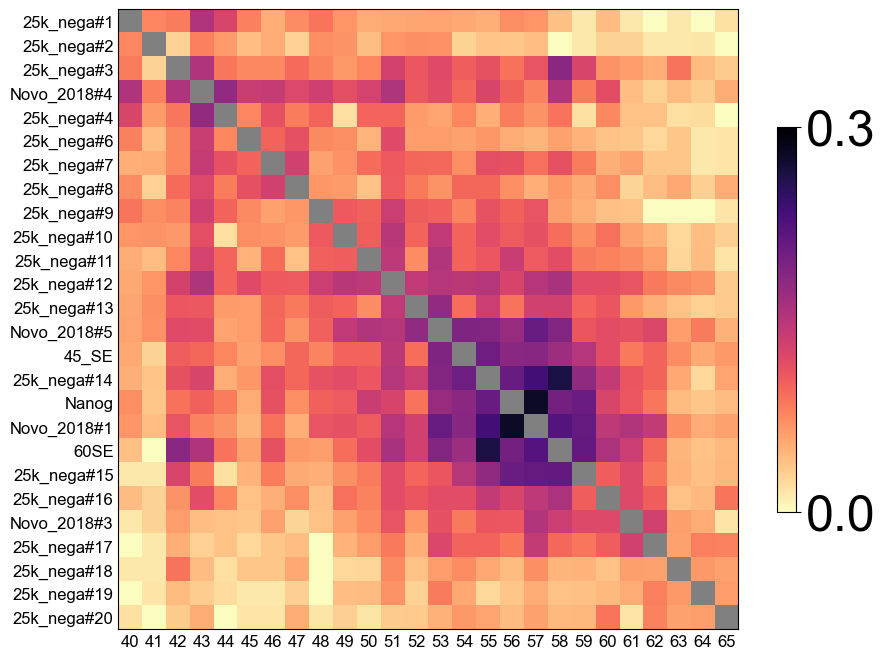

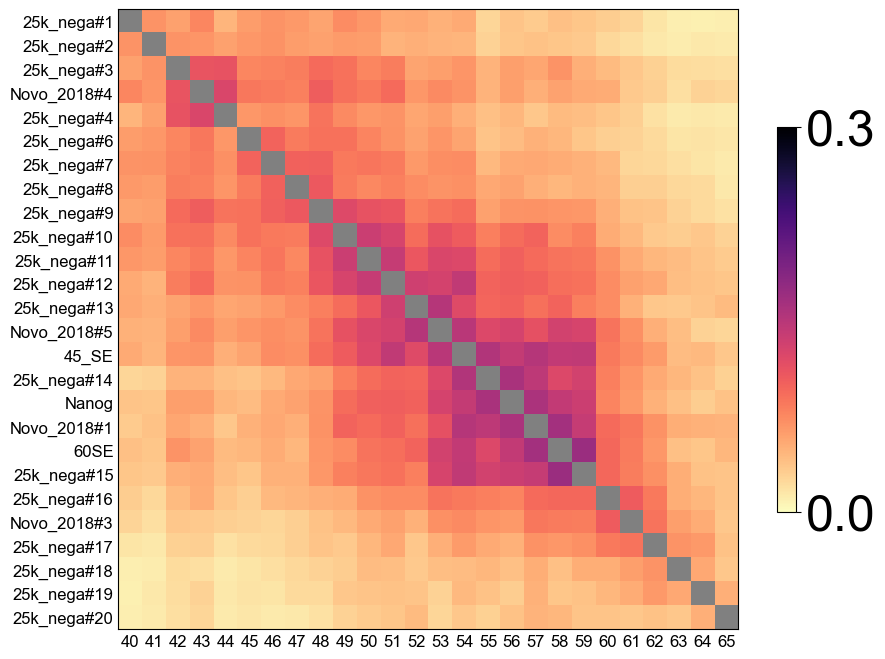

In [31]:
plt_matrix(mean_on_2, C_MIN=0.0, C_MAX=0.3, c = "magma_r")
plt_matrix(mean_off_2, C_MIN=0.0, C_MAX=0.3, c = "magma_r")